**MASK WEAR DETECTION WITH LOGISTIC REGRESSION :**

First, we have to load set of images.

To begin, we will load 2 sets of 100 images (1 dataset with worn mask and 1 dataset with unworn mask).

In [26]:
import numpy as np
from PIL import Image
import os
import cv2
import torch

def load_images_from_folder(folder):
    '''load all the images from a folder'''
    images = []
    for filename in os.listdir(folder):
        '''
        Python method listdir() returns a list containing the names of the 
        entries in the directory given by path. The list is in arbitrary order. 
        It does not include the special entries '.' and '..' even if they are 
        present in the directory.'''
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = img[:,:,::-1] # To shuffle the color channels form BGR to RGB.
            # A REGARDER COMMENT CA MARCHE PLUS EN DETAIL 
            images.append(img)
    return images

#dataset_w_m = torch.from_numpy(np.array(load_images_from_folder('Worn_Mask')))
#dataset_unw_m = torch.from_numpy(np.array(load_images_from_folder('Unworn_Mask')))

dataset_w_m_array = np.array(load_images_from_folder('Worn_Mask'))
dataset_unw_m_array = np.array(load_images_from_folder('Unworn_Mask'))

In [ ]:
Show the first element of the dataset

In [27]:
dataset_w_m_array[0]

array([[[  3, 135, 148],
        [  4, 136, 149],
        [  4, 134, 148],
        ...,
        [  0, 115, 148],
        [  0, 117, 150],
        [  0, 116, 149]],

       [[  0, 130, 143],
        [  2, 134, 147],
        [  5, 135, 149],
        ...,
        [  0, 116, 149],
        [  0, 117, 150],
        [  0, 116, 149]],

       [[  0, 127, 142],
        [  0, 131, 146],
        [  3, 133, 149],
        ...,
        [  0, 116, 151],
        [  0, 116, 149],
        [  0, 114, 147]],

       ...,

       [[ 19, 150, 168],
        [ 17, 148, 166],
        [ 15, 146, 164],
        ...,
        [128, 153, 158],
        [134, 157, 163],
        [135, 160, 165]],

       [[ 16, 149, 168],
        [ 16, 149, 168],
        [ 14, 147, 166],
        ...,
        [130, 158, 162],
        [132, 157, 162],
        [130, 158, 162]],

       [[ 15, 148, 167],
        [ 16, 149, 168],
        [ 15, 148, 167],
        ...,
        [132, 160, 164],
        [132, 160, 164],
        [130, 158, 162]]

In [28]:
def dataset_worn_mask(list_image_array) :
    '''print images from an list of array images
    array images = images representing by an array
    return list of PIL images'''
    dataset = []
    for image_array in list_image_array :
        img = (Image.fromarray(image_array, 'RGB'),0)
        dataset.append(img)
    return dataset

def dataset_unworn_mask(list_image_array) :
    '''print images from an list of array images
    array images = images representing by an array
    return list of PIL images'''
    dataset = []
    for image_array in list_image_array :
        img = (Image.fromarray(image_array, 'RGB'),1)
        dataset.append(img)
    return dataset

dataset_w_m = dataset_worn_mask(dataset_w_m_array)
dataset_unw_m = dataset_unworn_mask(dataset_unw_m_array)

Show the 16th image of the dataset_unw_m :

<class 'PIL.Image.Image'>
<class 'int'>
Label: 1


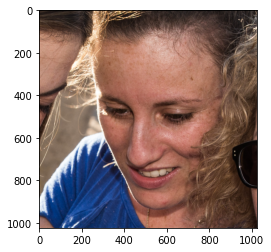

In [29]:
import matplotlib.pyplot as plt
image, label = dataset_unw_m[15]
print(type(image))
print(type(label))
plt.imshow(image, cmap='gray') # cmap for color mapping
print('Label:', label)

In [40]:
import torchvision.transforms as transforms

dataset_unw_m = torch.from_numpy(dataset_unw_m_array)
dataset_kl = torch.from_numpy(dataset_w_m)


TypeError: expected np.ndarray (got list)